# _*Qiskit Finance: Portfolio Optimization*_ 


### Introduction

[](attachment:portfoli.png)
<img src="attachment:portfoli.png" width="400">
This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$

where we use the following notation:
- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $p(1^T x - B)^2$ which is scaled by a parameter $p$ and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose groundstate corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) to find the optimal solution for a given set of parameters.

In [1]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](../data_providers/time_series.ipynb)

In [2]:
# set number of assets (= number of qubits)
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30))
data.run()


The underlying evolution of stock prices:


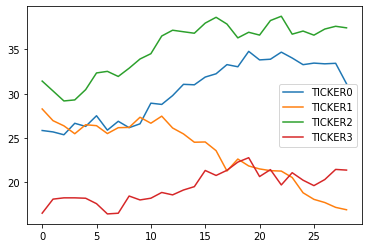

TICKER0
[25.85663552358504, 25.69701399897626, 25.37566295446746, 26.670937062071914, 26.316541753429867, 27.521798725379178, 25.896804706070782, 26.89723368178082, 26.17527004598191, 26.611291311197355, 28.941067953050815, 28.80054206386951, 29.79464018030633, 31.067330694011076, 31.014749630940308, 31.888254722178086, 32.25870074661928, 33.292418928789594, 33.050356641967866, 34.78732223373937, 33.824227286900104, 33.90098979621672, 34.699716827062176, 34.03844839616775, 33.28660782351866, 33.463666343663746, 33.38230163984339, 33.440812492400475, 31.131316381795415]
TICKER1
[28.287668230059406, 26.963514137658954, 26.38276490460429, 25.493221654334214, 26.508038730878077, 26.400528497236564, 25.509211733453316, 26.17473714313697, 26.205848043093383, 27.350272978439133, 26.67761058610594, 27.47519045360327, 26.1413731784514, 25.471583228302034, 24.532686823429238, 24.56285515878205, 23.58131940680797, 21.289664685570244, 22.63561430322609, 21.855623411170015, 21.519923219745827, 21.3

In [3]:
print("The underlying evolution of stock prices:")
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.show()

for (cnt, s) in enumerate(data._tickers):
    print(s)
    print(data._data[cnt])

In [4]:
mu = data.get_period_return_mean_vector() #average increase
sigma = data.get_period_return_covariance_matrix() #covariance matrix of increase
q = 0.5 # set risk factor
budget = 2 # set budget
penalty = 4 # set parameter to scale the budget penalty term



### Mathematical Formulation

We wish to minimize 
\begin{equation}
    \min_x(qx^T\Sigma x-\mu^T x)
\end{equation}
subject to 
\begin{equation}
    (1,...,1)x = B.
\end{equation}

The constraint can be converted into a penalty term $p(1^Tx-B)^2$. The function to minimize becomes
\begin{equation}
    \min_x\{qx^T\Sigma x - \mu^T x +p\cdot|(1,...,1)x-B|^2\}.
\end{equation}

Then, substitute $\frac{1-Z_i}{2}$ for $x_i$ since $x_i\in\{0, 1\}$ and eigenvalues of $Z_i$ are $\pm 1$.

With this substitution, cost function can be written as 

\begin{equation}
    \sum_{i\neq j}c_{ij}Z_iZ_j + \sum_ic_iZ_i + \text{const.}
\end{equation}
for some coefficients and constant related to $q, \Sigma, \mu, p, N, $ etc.

In [22]:
(qubitOp, offset) = portfolio.get_portfolio_qubitops(mu, sigma, q, budget, penalty)
algo_input = EnergyInput(qubitOp)
print(qubitOp.print_operators())

IIIZ	0.003258018115791446
IIZI	-0.009189766884836822
IIZZ	1.9999839519841243
IZII	0.0030490489348686633
IZIZ	2.0000516246228464
IZZI	2.000065550578841
ZIII	0.004586887039946586
ZIIZ	2.000020349809768
ZIZI	2.0000321962789545
ZZII	1.9999593309123544



We define some utility methods to print the results in a nice format.

In [23]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = portfolio.sample_most_likely(result['eigvecs'][0])
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    probabilities = np.abs(result['eigvecs'][0])**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

### ExactEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. To run an algorithm we need to prepare a configuration params dictionary. We set the algorithm for the ExactEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The params, along with the algo input containing the operator, are now passed to the algorithm to be run. The result is returned as a dictionary.

In [24]:
exact_eigensolver = ExactEigensolver(qubitOp, k=1)
result = exact_eigensolver.run()

""" the equivalent if using declarative approach
algorithm_cfg = {
    'name': 'ExactEigensolver'
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params, algo_input)
"""

print_result(result)

Optimal: selection [1 0 0 1], value -0.0157

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0157		1.0000
 [1 1 1 1]	15.9966		0.0000
 [0 1 1 1]	4.0030		0.0000
 [1 0 1 1]	3.9780		0.0000
 [0 0 1 1]	-0.0156		0.0000
 [1 1 0 1]	4.0025		0.0000
 [0 1 0 1]	0.0091		0.0000
 [0 0 0 1]	3.9908		0.0000
 [1 1 1 0]	4.0057		0.0000
 [0 1 1 0]	0.0122		0.0000
 [1 0 1 0]	-0.0127		0.0000
 [0 0 1 0]	3.9937		0.0000
 [1 1 0 0]	0.0115		0.0000
 [0 1 0 0]	4.0182		0.0000
 [1 0 0 0]	3.9934		0.0000
 [0 0 0 0]	16.0000		0.0000


### Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [25]:
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'COBYLA',
    'maxiter': 500
}

var_form_cfg = {
    'name': 'RY',
    'depth': 3,
    'entanglement': 'full'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg
}
result = run_algorithm(params, algo_input, backend=backend)
"""
print_result(result)

Optimal: selection [0 1 1 0], value 0.0122

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	0.0122		0.4185
 [1 1 0 0]	0.0115		0.3286
 [1 0 1 0]	-0.0127		0.2336
 [0 1 0 1]	0.0091		0.0115
 [1 0 0 1]	-0.0157		0.0046
 [0 0 1 1]	-0.0156		0.0032
 [0 1 1 1]	4.0030		0.0000
 [1 1 0 1]	4.0025		0.0000
 [1 0 1 1]	3.9780		0.0000
 [0 0 0 1]	3.9908		0.0000
 [1 1 1 1]	15.9966		0.0000
 [1 1 1 0]	4.0057		0.0000
 [0 0 0 0]	16.0000		0.0000
 [1 0 0 0]	3.9934		0.0000
 [0 0 1 0]	3.9937		0.0000
 [0 1 0 0]	4.0182		0.0000


reference:


https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/finance/optimization/portfolio_optimization.ipynb


https://github.com/Qiskit/qiskit-tutorials/blob/d8308cdf717046923a8f01e0c899ef3f19401c63/qiskit/finance/data_providers/time_series.ipynb
